# Поиск наиболее похожих товаров

## Введение

Заказчик предоставил анонимизированный набор имеющихся на складах товаров и набор **новых товаров**, для которых необходимо **найти наиболее похожие** из имеющегося набора. 

Особенность задачи состоит в том, что автоматический подбор похожих товаров должен производиться так, чтобы **симулировать работу экспертов**. Образцы их ответов предоставлены для обучения модели в отдельном файле вместе с примерами запросов.


### Описание данных

- <u>base.csv</u> - анонимизированный **набор товаров**. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- <u>train.csv</u> - **обучающий датасет**. Каждая строчка - один товар, для которого известен уникальный id (0-query, …, 100000-query), вектор признаков и id товара из base.csv, который максимально похож на него по мнению экспертов.

- <u>validation.csv</u> - **датасет с товарами** (уникальный id и вектор признаков), **для которых надо найти наиболее близкие** товары из base.csv.

- <u>validation_answer.csv</u> - **правильные ответы** к датасету с товарами для поиска (даётся **для оценки** работы простроенной **модели**).


### Задачи

- **разработать алгоритм**, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv;
- **оценить качество алгоритма** по метрике **accuracy@5**.


## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import faiss
import datetime as dt

from adjdatatools.preprocessing import AdjustedScaler
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
RANDOM_STATE = 12345

# Загрузка данных

In [2]:
# функция для предварительного знакомства с данными
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

## Анонимизированный набор товаров

In [3]:
# открываем файл с анонимизированным набором товаров 
df_base = pd.read_csv("datasets/base.csv", index_col=0)

In [4]:
first_look(df_base)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39 

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

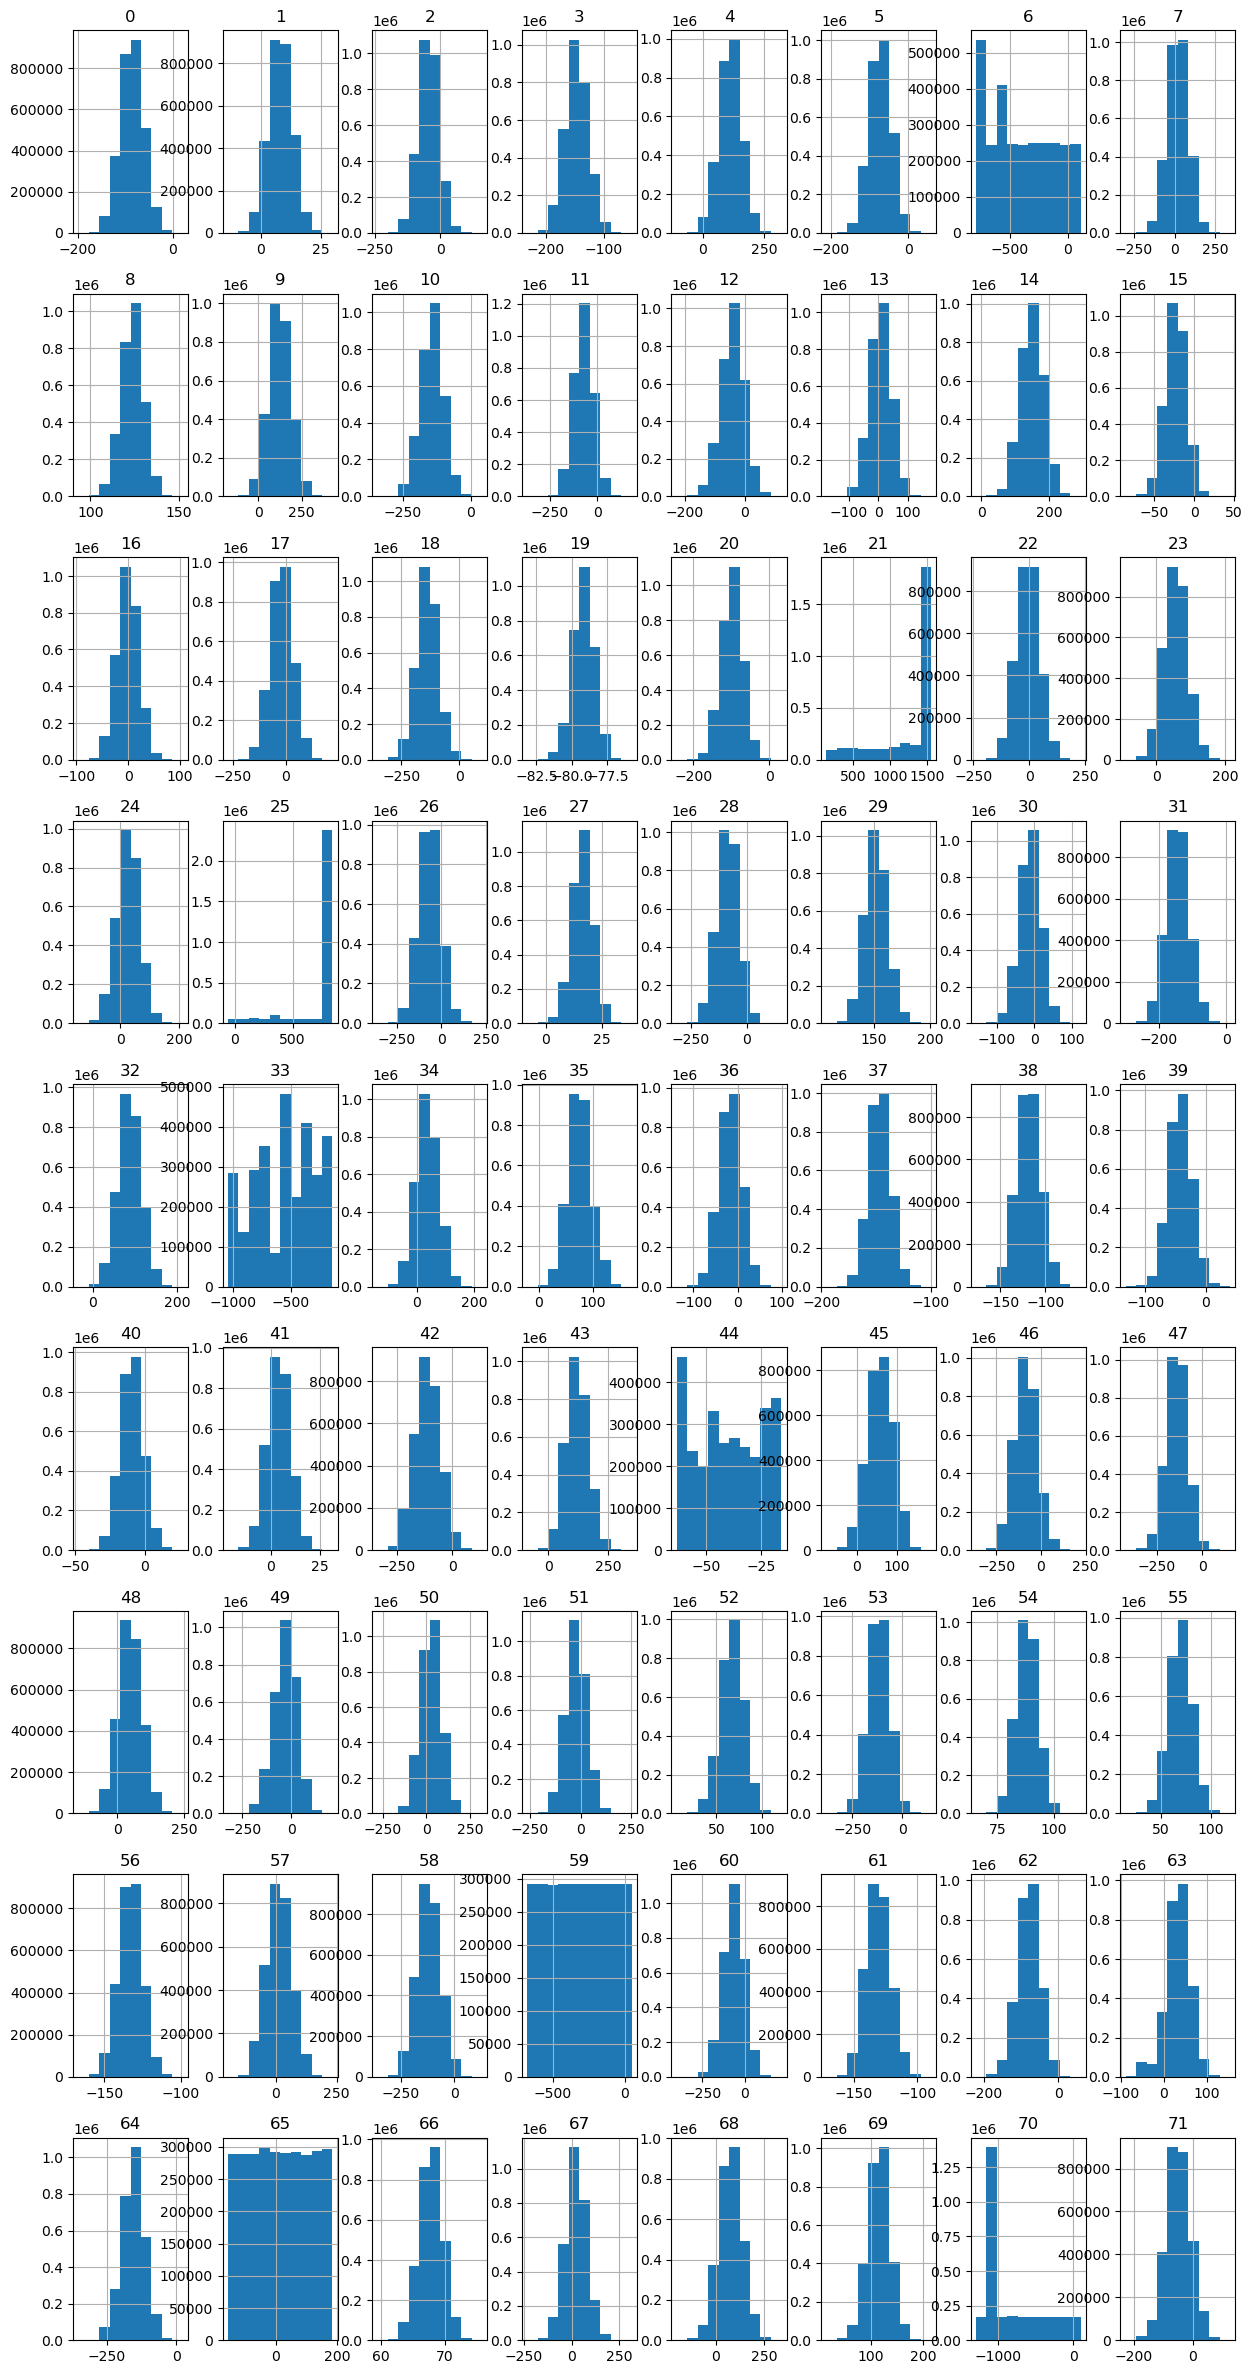

In [5]:
df_base.hist(figsize=(15, 30));

### Вывод

Набор товаров, среди которых нам нужно проводить поиск содержит **почти 3 млн образцов**.

Данные зашифрованы. Для каждого образца товара имеется **72 характеристики**, все представляют собой **дробные числа.  Пропусков нет**.

**Дубликатов** в наборе **нет**.

**Данные ненормированные** – диапазоны их значений отличаются. **Большинство признаков** имеют **распределение, близкое к нормальному**. Более **подробные графики** по всем признакам хранятся **в папке charts**. 

**Отличия в распределении** наблюдаются у следующих признаков:
- признак номер 6 – большинство значений представлены небольшим количеством наблюдений (не больше 10), но есть два значения, для которых количество образцов больше 150 000.
- признаки номер 21, 25 и 71 – аналогично, но пиковое значение одно
- признак номер 33 – значения распадаются на 5 групп примерно с одинаковым количеством образцов
- признак номер 41 имеет 3 наиболее частых значения
- признак номер 44 – 4 группы значений со значительно бОльшим количеством образцов, чем остальные значения
- признак номер 45 – среди значений можно выделить 2 группы (бимодальное распределение)
- признак номер 54 – среди значений можно выделить 3 пиковые группы
- признак номер 59 – практически все значения имеют по 2 образца в наборе данных
- признак номер 60 – среди значений можно выделить порядка 10 пиковых групп


## Данные, для которых даны оценки экспертов

In [6]:
# открываем файл
df_train = pd.read_csv("datasets/train.csv", index_col=0)

In [7]:
first_look(df_train)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Количество пропусков:
0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

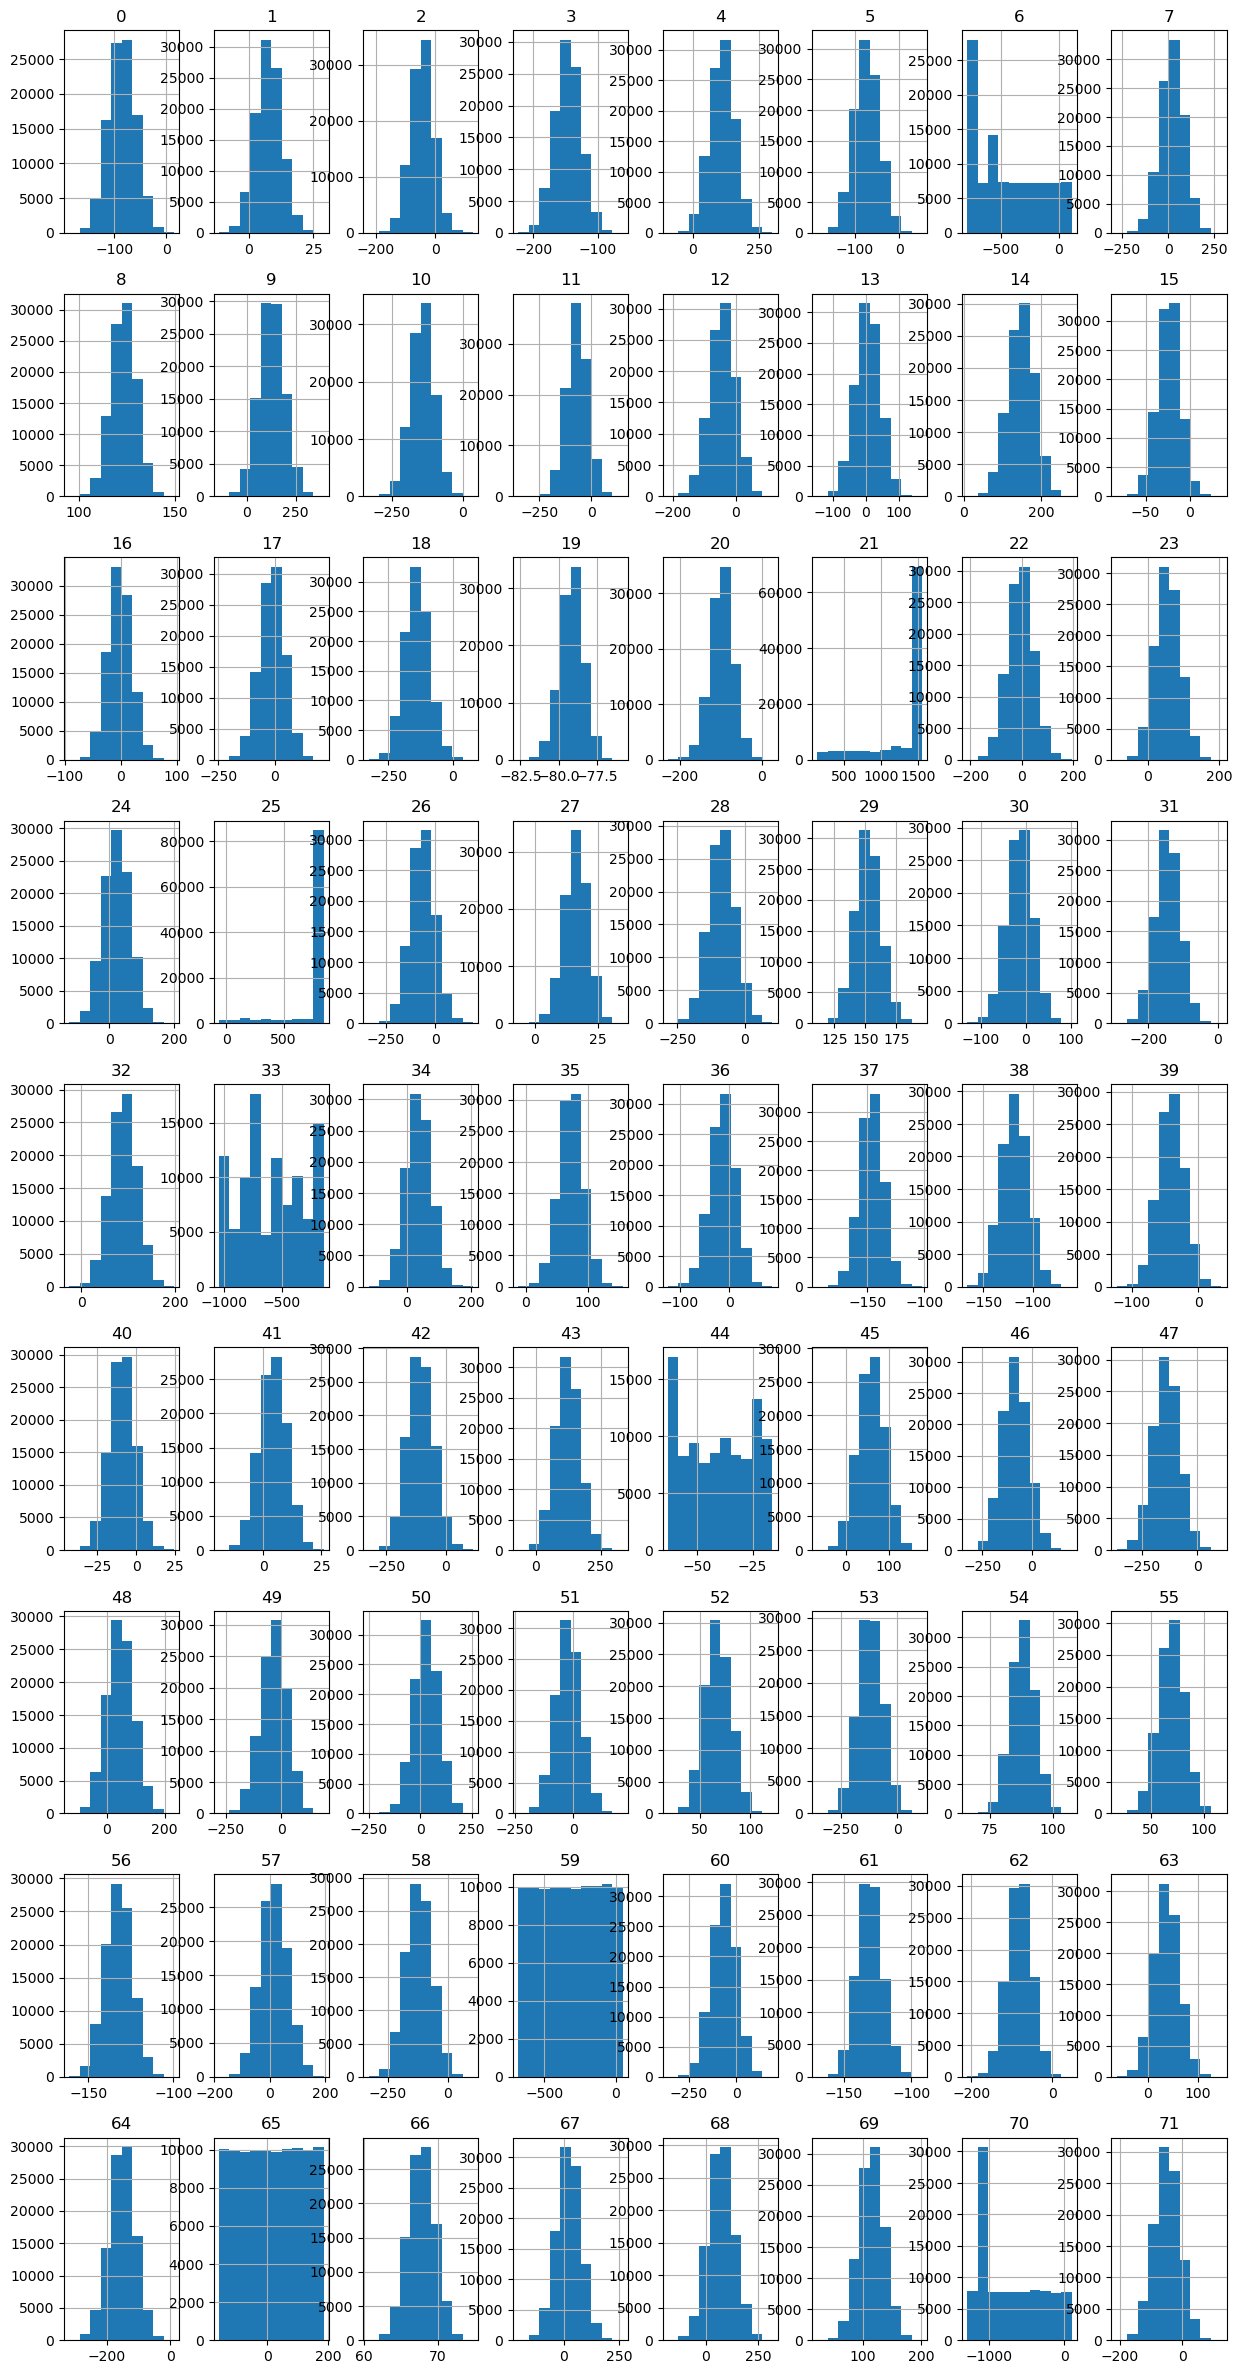

In [8]:
df_train.hist(figsize=(15, 30));

Данные, для которых даны оценки экспертов, содержат 100 000 строк без пропусков и дубликатов. Характеристики имеют те же распределения, что и в базовом датасете.

Оценки экспертов содержатся в отдельном столбце target. Выделим его в отдельную переменную для последующей передачи модели.


In [9]:
# разделим запросы и ответы экспертов
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

## Данные для проверки качества модели

In [10]:
# открываем файл
df_validation = pd.read_csv("datasets/validation.csv", index_col=0)

In [11]:
first_look(df_validation)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

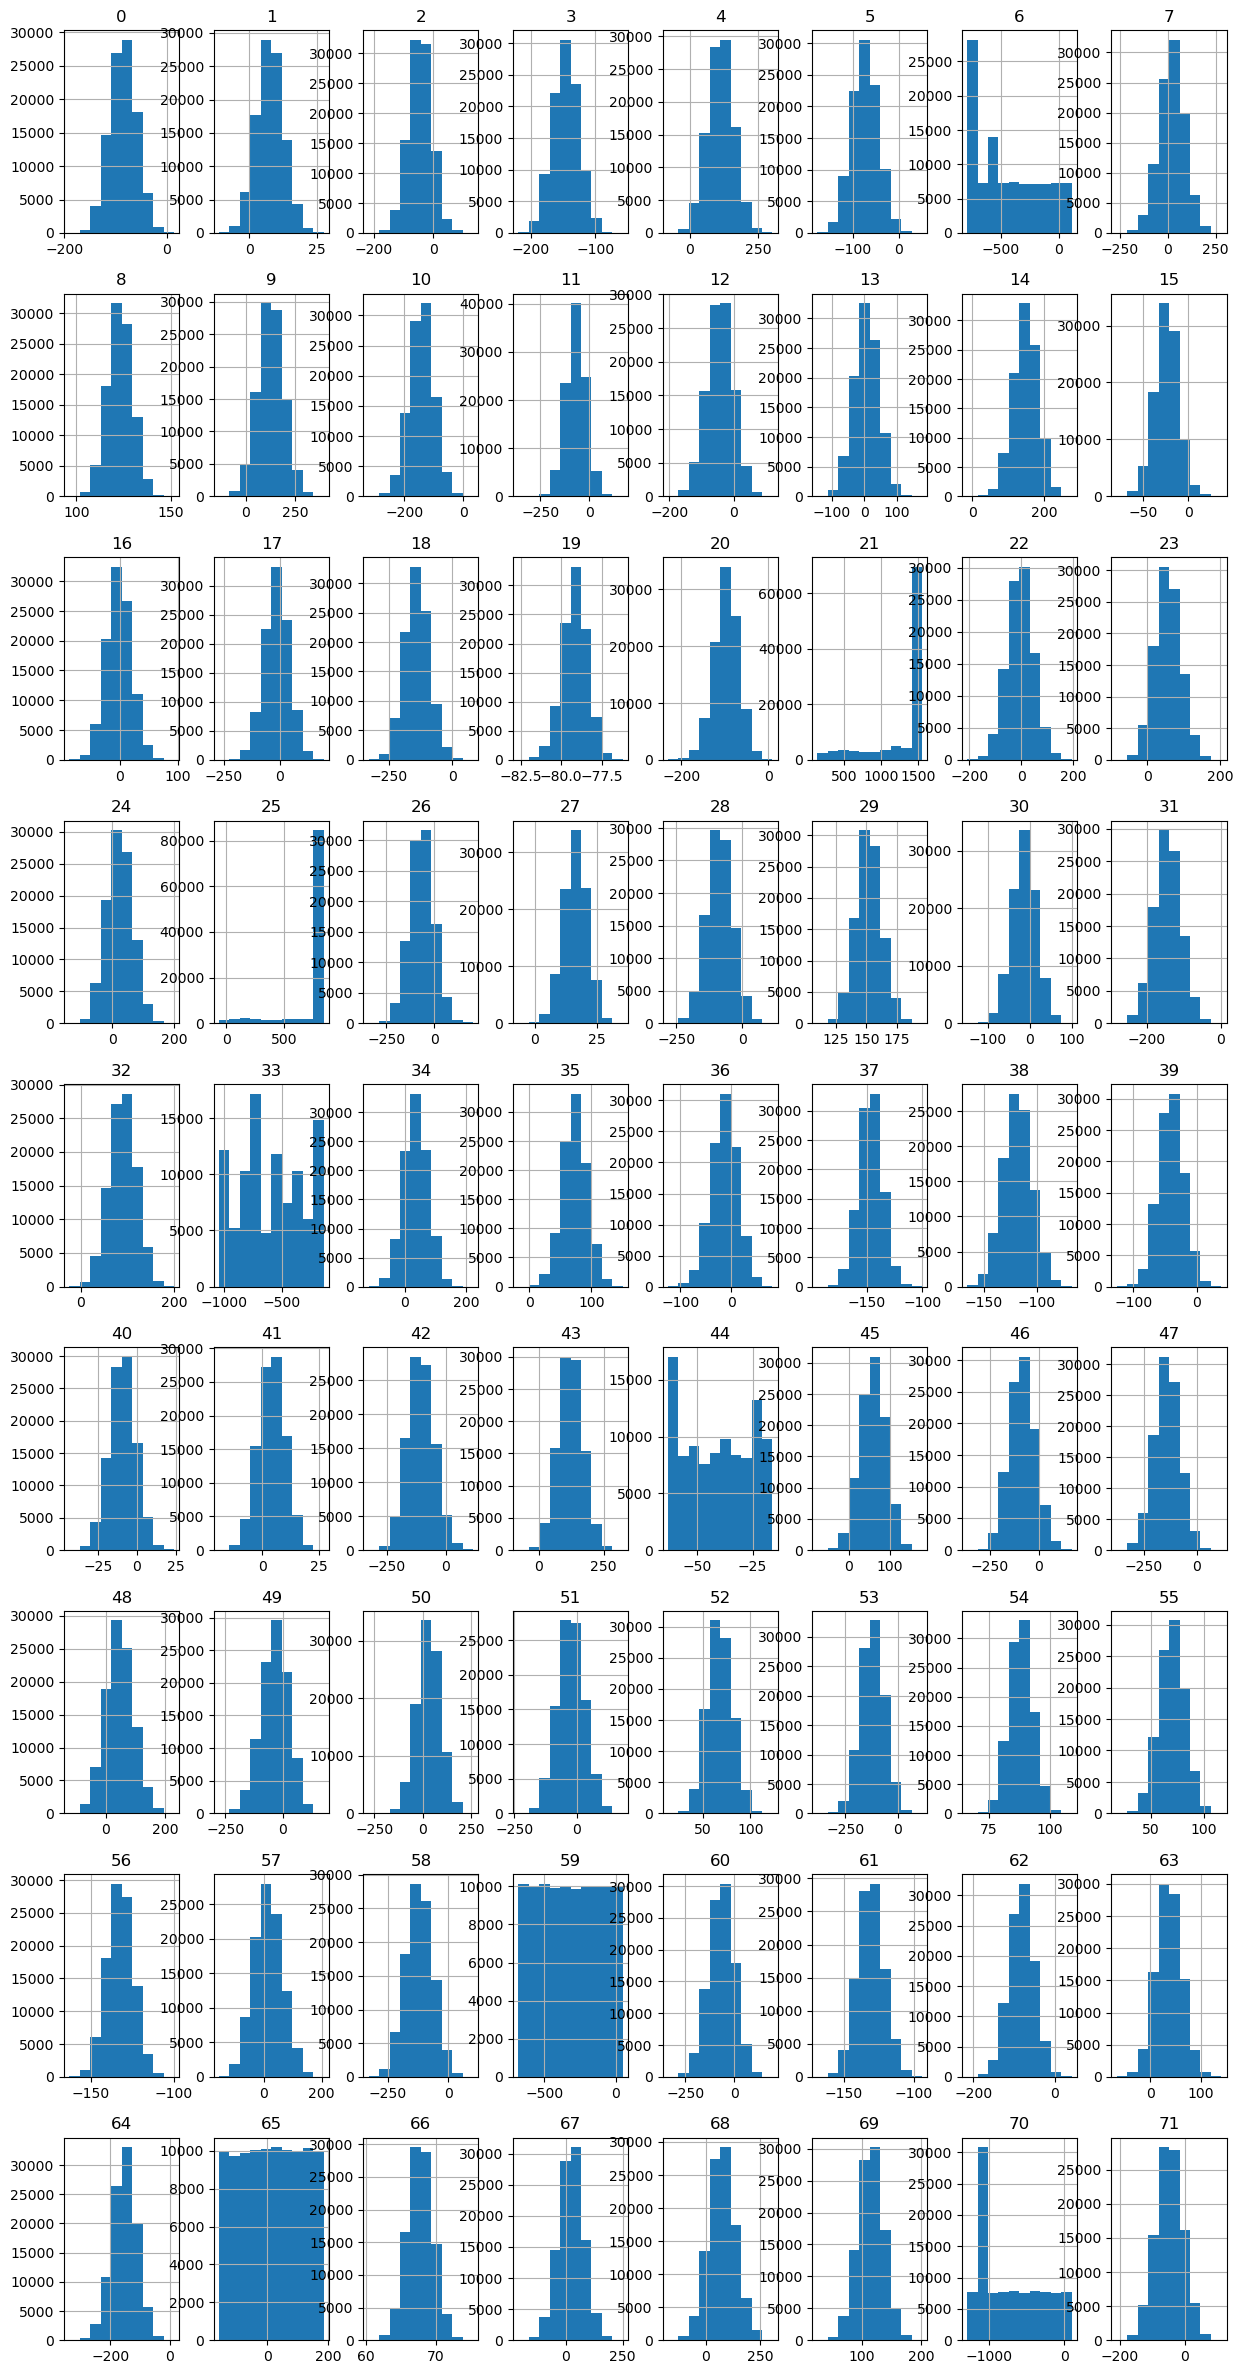

In [12]:
df_validation.hist(figsize=(15, 30));

Запросы, для которых необходимо подобрать похожие товары в соответствии с рекомендациями экспертов, содержат 100 000 строк без пропусков и дубликатов. Характеристики имеют те же распределения, что и в базовом датасете.

## Вывод после предварительного знакомства с данными

На доступны **три набора данных**:
- 3 млн товаров, среди которых мы должны подбирать похожие на входные запросы
- 100 000 строк запросов с ответами экспертов
- 100 000 запросов для подбора похожих товаров с помощью разрабатываемой модели.

Все три набора данных **зашифрованы**. Для каждого образца товара имеется **72 характеристики**, все представляют собой дробные числа. **Пропусков и дубликатов нет** ни в одном наборе.

Данные **ненормированные** – диапазоны их значений отличаются. 

**Характер распределений для каждого признака одинаков по всем трем датасетам**. 61 признак из 72 имеет распределение, близкое к нормальному. Распределения 11 признаков отличаются: либо имеют несколько самых популярных значений, либо их можно разбить на несколько групп.


# Нормализация данных

Так как формула для расчёта расстояния между точками в пространстве чувствительна к диапазону значений различных характеристик, предварительно нормализуем данные.

Для этого используем метод AdjustedScaler из библиотеки adjdatatools.


In [13]:
scaler = AdjustedScaler()

Будем обучать трансформер данных на базовом датасете, потом преобразуем с его помощью все три набора данных.

In [14]:
# обучение
scaler.fit(df_base)

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_sample = data_sample.append(new_data_sample, ignore_index=True)[[column_name]]
C:\Users\Admin\anaconda3\Lib\site-packages\adjdatatools\preprocessing.py:117: FutureWarning: The frame.append

In [15]:
# нормализация базового набора товаров
df_base = scaler.transform(df_base)

In [16]:
# результат нормализации
df_base = pd.DataFrame(df_base)
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,1.498675e-05,1.525386e-03,-3.853427e-03,1.337707e-03,-2.257473e-03,-4.438503e-04,3.326787e-02,-1.312582e-03,-6.174725e-03,2.826532e-03,...,-3.336287e-03,-1.013437e-02,-3.849022e-03,9.466092e-04,-2.351670e-03,4.444265e-04,8.932247e-05,-4.134040e-03,2.314199e-01,3.603087e-03
std,1.840861e-01,1.837190e-01,1.947977e-01,1.871858e-01,1.880570e-01,1.811105e-01,3.014696e-01,1.865039e-01,1.886739e-01,1.896328e-01,...,1.900202e-01,2.064947e-01,1.937820e-01,2.887462e-01,1.871613e-01,1.915506e-01,1.868125e-01,1.912465e-01,3.241872e-01,1.878607e-01
min,-8.374565e-01,-8.142482e-01,-9.896125e-01,-8.101590e-01,-8.823258e-01,-8.937035e-01,-4.097961e-01,-9.371159e-01,-9.124583e-01,-8.752215e-01,...,-8.864376e-01,-8.808702e-01,-9.396710e-01,-5.002191e-01,-8.524942e-01,-8.879874e-01,-8.482056e-01,-9.058724e-01,-1.879671e-01,-8.018234e-01
25%,-1.244970e-01,-1.235253e-01,-1.298069e-01,-1.238320e-01,-1.272635e-01,-1.250257e-01,-2.298631e-01,-1.249613e-01,-1.308544e-01,-1.228207e-01,...,-1.265023e-01,-1.267189e-01,-1.259750e-01,-2.484073e-01,-1.266269e-01,-1.243704e-01,-1.253260e-01,-1.294935e-01,0.000000e+00,-1.218315e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.255397e-01,1.272586e-01,1.219833e-01,1.268589e-01,1.237587e-01,1.251770e-01,2.946758e-01,1.252145e-01,1.210576e-01,1.286857e-01,...,1.244982e-01,1.247378e-01,1.251957e-01,2.504887e-01,1.244165e-01,1.257753e-01,1.246921e-01,1.221793e-01,4.783747e-01,1.299460e-01
max,7.968536e-01,8.121972e-01,1.032458e+00,8.998779e-01,8.431124e-01,8.400004e-01,5.902039e-01,9.306071e-01,8.421000e-01,8.948666e-01,...,8.651255e-01,8.539199e-01,8.382085e-01,4.997809e-01,8.106467e-01,1.008879e+00,8.059137e-01,8.912585e-01,9.868579e-01,7.900206e-01


In [17]:
# нормализация тренировочного набора товаров
df_train = scaler.transform(df_train)

In [18]:
# результат нормализации
df_train = pd.DataFrame(df_train)
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.006677,-0.013894,0.000754,0.006208,-0.000416,-0.008074,-0.020434,0.001240,-0.024470,0.007719,...,-0.016580,0.015607,0.008245,0.000510,-0.001542,-0.001340,-0.004622,-0.007539,0.306767,0.000388
std,0.190835,0.183803,0.197215,0.192751,0.193546,0.184534,0.309640,0.191641,0.192710,0.191052,...,0.191389,0.181272,0.192800,0.289121,0.188666,0.191995,0.189426,0.194923,0.341471,0.185463
min,-0.739920,-0.726936,-0.913082,-0.721872,-0.832374,-0.726343,-0.409796,-0.869513,-0.862646,-0.781878,...,-0.820884,-0.682651,-0.770133,-0.500207,-0.733481,-0.786256,-0.782343,-0.843785,-0.187917,-0.726026
25%,-0.126299,-0.138165,-0.129479,-0.124997,-0.131457,-0.134369,-0.351054,-0.124701,-0.154879,-0.120532,...,-0.143603,-0.106802,-0.117278,-0.249705,-0.128711,-0.130006,-0.131691,-0.139404,0.000000,-0.125486
50%,0.007084,-0.014320,0.004974,0.006691,0.001571,-0.009266,-0.099474,0.004282,-0.023887,0.007257,...,-0.014796,0.014271,0.011282,0.000717,-0.000102,0.000086,-0.006242,-0.007115,0.223460,-0.000490
75%,0.139782,0.109126,0.131622,0.136762,0.129385,0.117090,0.245350,0.130969,0.108333,0.135986,...,0.112277,0.137285,0.138842,0.251491,0.127710,0.126419,0.120408,0.124335,0.603416,0.126465
max,0.745600,0.774389,0.866921,0.811431,0.768857,0.795301,0.590196,0.776515,0.755868,0.792693,...,0.787507,0.793152,0.779675,0.499772,0.714965,0.841338,0.745902,0.774343,0.986856,0.786504


In [19]:
# нормализация набора товаров для валидации модели
df_validation = scaler.transform(df_validation)

In [20]:
# результат нормализации
df_validation = pd.DataFrame(df_validation)
df_validation.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.006872,-0.013694,-0.000130,0.006197,-0.000965,-0.008679,-0.021302,0.002293,-0.024178,0.007368,...,-0.016479,0.014754,0.007689,0.001666,-0.002637,-0.000574,-0.005529,-0.007474,0.307023,0.000791
std,0.190639,0.183853,0.197355,0.193324,0.193752,0.183229,0.309890,0.193072,0.193091,0.191255,...,0.191487,0.181768,0.193862,0.287999,0.189334,0.191764,0.188978,0.194118,0.341223,0.185812
min,-0.770043,-0.710222,-0.875981,-0.691156,-0.783388,-0.673285,-0.409785,-0.831831,-0.821468,-0.762777,...,-0.852659,-0.721873,-0.863201,-0.500217,-0.763368,-0.810230,-0.763913,-0.819651,-0.187961,-0.726026
25%,-0.125727,-0.138957,-0.130419,-0.126711,-0.132968,-0.134085,-0.353365,-0.123751,-0.155382,-0.121221,...,-0.144761,-0.108308,-0.118150,-0.245838,-0.130202,-0.129032,-0.132272,-0.139860,0.000000,-0.124949
50%,0.006913,-0.014133,0.002954,0.006569,0.000350,-0.010647,-0.101788,0.003872,-0.024628,0.007611,...,-0.015842,0.012146,0.011991,0.002747,-0.001451,0.000319,-0.008458,-0.006715,0.224951,-0.000351
75%,0.139107,0.109598,0.131359,0.138257,0.129964,0.116053,0.243734,0.131544,0.108249,0.135926,...,0.113635,0.137063,0.139014,0.250887,0.125871,0.127159,0.119945,0.124147,0.602312,0.127385
max,0.744437,0.718456,0.900965,0.843216,0.771704,0.785056,0.590203,0.751239,0.829079,0.792693,...,0.747933,0.759969,0.792340,0.499770,0.778667,0.788711,0.703482,0.772887,0.986830,0.721887


## Вывод после предобработки данных

В результате нормализации диапазоны значений всех признаков лежат внутри отрезка [-1, 1]. Медианное значение приравнено к нулю в базовом датасете, в остальных незначительно отклоняется от нуля.

# Поиск ближайших соседей

Для того, чтобы найти в базовом наборе товары, похожие на наш запрос, воспользуемся библиотекой FAISS.

Будем находить евклидово расстояние между векторами, соответствующими запросу и векторами, соответствующими товарам в базовом наборе.


In [21]:
# инициализация индекса
dims = df_base.shape[1]
n_cells = 1
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [22]:
# подготовка к поиску
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [23]:
# создание словаря для нахождения индекса товара в базовом наборе данных
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

## Поиск по обучающей выборке

Проведем поиск по обучающей выборке и сравним его результаты с рекомендациями экспертов.

На первом этапе будем искать 100 ближайших соседей.

In [24]:
# измерим время поиска
start_time = dt.datetime.now().timestamp()
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 100)
time_spent = dt.datetime.now().timestamp() - start_time
print(f'Время поиска: {time_spent // 60} минут и {time_spent % 60} секунд')

Время поиска: 39.0 минут и 29.52396297454834 секунд


Проанализируем результаты поиска. Выясним, сколько в первой сотне вариантов, отобранных с помощью FAISS, содержится товаров, рекомендованных экспертами и как они распределены в выдаче.

In [25]:
# accuracy@1100
acc_100 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_100 += int(target in [base_index[r] for r in el])

print(100 * acc_100 / len(idx))

71.097


Посмотрим, сколько рекомендаций экспертов попало в первую десятку.

In [26]:
# accuracy@10
acc_10 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_10 += int(target in [base_index[r] for r in el[:10]])

print(100 * acc_10 / len(idx))

58.323


Посмотрим, сколько рекомендаций экспертов попало в первую пятерку

In [27]:
# accuracy@5
acc_5 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_5 += int(target in [base_index[r] for r in el[:5]])

print(100 * acc_5 / len(idx))

54.004


Видим, что результат не очень высокий. 

При отборе только пяти ближайших векторов с помощью FAISS теряется почти 20% правильных ответов, которые содержатся в выборке ста ближайших соседей.

Так как нам нужно создать систему, дающую по 5 предсказаний на каждый запрос, будем искать способ отобрать их этой сотни 5 кандидатов, наиболее похожих на ответы экспертов.

Для начала исследуем выдачу и постараемся выяснить:
- какие места занимают ответы экспертов в выдаче FAISS чаще всего
- возможно, рекомендации экспертов находятся не на каких-то определенных местах в выдаче, а на заданном расстоянии от вектора запроса.


## Анализ результатов поиска

Соберем в таблицу следующие сведения о 100 кандидатах, предложенных FAISS:
- min – расстояние от самого близкого соседа до вектора запроса
- max – расстояние от сотого соседа до вектора запроса
- distance – расстояние от вектора, рекомендованного экспертами, до вектора запроса (NaN, если среди выдачи FAISS он не числится)
- n_in_a_list – порядковый номер вектора, рекомендованного экспертами, в выдаче FAISS (NaN, если среди выдачи FAISS он не числится)
- middle – расстояние от запроса до середины диапазона расстояний в 100 отобранных FAISS (между самым близким и самым дальним соседями)
- dist_from_midle – расстояние от вектора, рекомендованного экспертами, до середины диапазона выдачи


In [28]:
list_of_analysis = []
for target, el, dist in zip(targets.values.tolist(), idx.tolist(), vecs.tolist()):
    row = []
    # индекс верного ответа для данного запроса по версии экспертов
    row.append(target)
    # расстояние от самого близкого соседа до вектора запроса
    row.append(dist[0])
    
    target_not_found = True
    for r in range(len(el)):
        if target == base_index[el[r]]:
            # расстояние от вектора, рекомендованного экспертами, до вектора запроса
            row.append(dist[r])
            # порядковый номер вектора, рекомендованного экспертами, в выдаче 
            row.append(r)
            
            target_not_found = False
    if target_not_found:
        row.append(np.nan)
        row.append(np.nan)
        
    # расстояние от сотого соседа до вектора запроса
    row.append(dist[99])
    list_of_analysis.append(row)

In [29]:
# преобразуем в pandas DataFrame
columns = ['target', 'min', 'distance', 'n_in_a_list', 'max']
df_analysis = pd.DataFrame(list_of_analysis, columns=columns)

In [30]:
# расстояние от запроса до середины диапазона расстояний в 100 отобранных FAISS 
df_analysis['middle'] = df_analysis['min'] + (df_analysis['max'] + df_analysis['min']) / 2

In [31]:
# расстояние от вектора, рекомендованного экспертами, до середины диапазона выдачи
df_analysis['dist_from_midle'] = df_analysis['middle'] - df_analysis['distance']

Посмотрим на результаты анализа.

In [32]:
df_analysis

,target,min,distance,n_in_a_list,max,middle,dist_from_midle
0,675816-base,0.935517,0.935517,0.0,1.748360,2.277456,1.341939
1,366656-base,1.023550,NaN,NaN,2.568082,2.819366,NaN
2,1447819-base,0.832889,1.660952,87.0,1.694077,2.096372,0.435421
3,1472602-base,0.977136,0.977136,0.0,2.567662,2.749535,1.772399
4,717819-base,0.087355,0.469511,24.0,0.606344,0.434205,-0.035305
...,...,...,...,...,...,...,...
99995,811868-base,1.079456,NaN,NaN,2.331912,2.785140,NaN
99996,1460772-base,1.556390,NaN,NaN,2.610435,3.639803,NaN
99997,2366140-base,0.420504,0.428560,1.0,2.190548,1.726030,1.297470
99998,9252-base,0.134091,NaN,NaN,0.351688,0.376981,NaN


Выведем сводную таблицу статистических характеристик 

In [33]:
df_analysis.describe()

,min,distance,n_in_a_list,max,middle,dist_from_midle
count,1.000000e+05,71097.000000,71097.000000,100000.000000,100000.000000,71097.000000
mean,7.485915e-01,0.929332,7.422592,2.190928,2.218351,1.261110
std,5.258679e-01,0.712266,17.499311,0.582000,0.932192,0.517524
min,7.137597e-08,0.000013,0.000000,0.015747,0.008017,-1.261021
25%,3.219169e-01,0.314667,0.000000,1.872768,1.521212,1.010477
50%,6.790635e-01,0.801768,0.000000,2.286767,2.096074,1.319783
75%,1.095656e+00,1.437301,4.000000,2.594300,2.813374,1.576715
max,2.894079e+00,3.647401,99.000000,4.165956,6.095569,3.261934


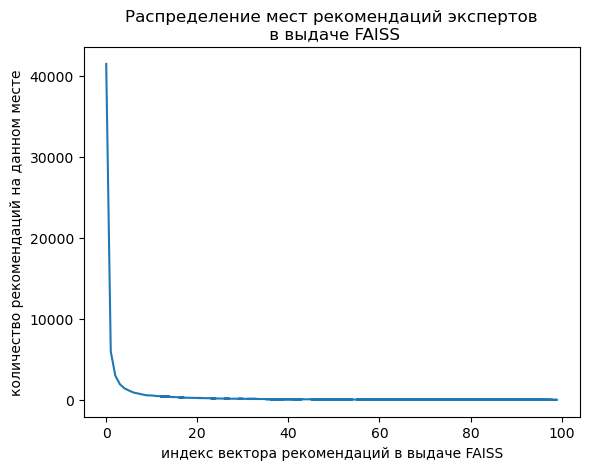

In [34]:
chart = df_analysis['n_in_a_list'].value_counts().plot()
chart.set_title('Распределение мест рекомендаций экспертов\n в выдаче FAISS')
chart.set_xlabel('индекс вектора рекомендаций в выдаче FAISS')
chart.set_ylabel('количество рекомендаций на данном месте')
chart;

### Вывод

Ответы экспертов в выдаче FAISS в 75 % случаев находятся **на местах с 1 по 5**. 

**Нет фиксированного расстояния** ни от вектора запроса, ни от середины диапазона рекомендаций, которое можно было бы использовать для более точного поиска средствами FAISS.

Следовательно, **имеет смысл обучить модель** отбирать из рекомендаций FAISS те, которые вероятнее всего похожие на рекомендации экспертов.


# Обучение модели

В качестве модели, которая отбирает 5 наиболее вероятных кандидатов будем использовать CatBoostClassifier. Подготовим для него обучающий датасет.

## Подготовка данных для обучения модели

Соберем в таблицу для каждого запроса из тренировочного набора данных по 5 строк, которые будут содержать:
- координаты вектора запроса,
- координаты вектора, рекомендованного FAISS (возьмем первые 5 рекомендаций),
- расстояние между этими векторами.


In [35]:
df_for_cb = pd.DataFrame() 

# для каждого запроса из обучающего набора данных
for i in range(df_train.shape[0]):
    
    # берем индексы FAISS для первых пяти рекомендаций
    df = pd.DataFrame(idx[i][:5])
    
    # берем расстояния от запроса до рекомендаций FAISS
    df = pd.concat([df, pd.DataFrame(vecs[i][:5])], axis=1)
    
    df.columns = ['idx', 'distance']
    
    # индекс вектора-запроса для получения его координат
    df['query_idx'] = str(i) +'-query'
    
    # индекс вектора рекомендаций экспертов
    df['target_idx'] = targets[i]
    
    df_for_cb = pd.concat([df_for_cb, df], ignore_index=True)
    

In [36]:
df_for_cb.head()

,idx,distance,query_idx,target_idx
0,598613,0.935517,0-query,675816-base
1,1934845,0.963750,0-query,675816-base
2,755584,0.975619,0-query,675816-base
3,450667,1.111103,0-query,675816-base
4,13374,1.159927,0-query,675816-base


In [37]:
# функция для получения индекса рекомендаций в базовом наборе товаров по индексу FAISS
def get_base_idx(row):
    return base_index[row['idx']]

In [38]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
df_for_cb['base_idx'] = df_for_cb.apply(get_base_idx, axis=1)
df_for_cb

,idx,distance,query_idx,target_idx,base_idx
0,598613,0.935517,0-query,675816-base,675816-base
1,1934845,0.963750,0-query,675816-base,2725256-base
2,755584,0.975619,0-query,675816-base,877519-base
3,450667,1.111103,0-query,675816-base,494555-base
4,13374,1.159927,0-query,675816-base,13406-base
...,...,...,...,...,...
499995,1958647,0.162424,99999-query,2769109-base,2769109-base
499996,1831967,1.671523,99999-query,2769109-base,2539368-base
499997,840740,1.902712,99999-query,2769109-base,990986-base
499998,1394495,1.960822,99999-query,2769109-base,1804388-base


Создаем **целевой признак**:
    
1 если индекс рекомендованного FAISS товара совпадает с индексом товара, выбранного экспертами

0 в противном случае.


In [39]:
df_for_cb['target'] = df_for_cb['target_idx'] == df_for_cb['base_idx']
df_for_cb['target'] = df_for_cb['target'].astype('int')
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target
0,598613,0.935517,0-query,675816-base,675816-base,1
1,1934845,0.963750,0-query,675816-base,2725256-base,0
2,755584,0.975619,0-query,675816-base,877519-base,0
3,450667,1.111103,0-query,675816-base,494555-base,0
4,13374,1.159927,0-query,675816-base,13406-base,0
...,...,...,...,...,...,...
499995,1958647,0.162424,99999-query,2769109-base,2769109-base,1
499996,1831967,1.671523,99999-query,2769109-base,2539368-base,0
499997,840740,1.902712,99999-query,2769109-base,990986-base,0
499998,1394495,1.960822,99999-query,2769109-base,1804388-base,0


Вместо индексов товаров мы будем использовать из координаты. Добавим их к нашим данным.

In [40]:
# добавляем координаты векторов-запросов
df_for_cb = df_for_cb.merge(df_train, how='inner', left_on='query_idx', right_index=True)
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target,0,1,2,3,...,62,63,64,65,66,67,68,69,70,71
0,598613,0.935517,0-query,675816-base,675816-base,1,0.239238,0.368392,0.008570,-0.350510,...,-0.168079,0.253006,-0.008579,-0.337892,-0.196136,0.038215,-0.037420,0.169245,0.554073,0.101847
1,1934845,0.963750,0-query,675816-base,2725256-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.168079,0.253006,-0.008579,-0.337892,-0.196136,0.038215,-0.037420,0.169245,0.554073,0.101847
2,755584,0.975619,0-query,675816-base,877519-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.168079,0.253006,-0.008579,-0.337892,-0.196136,0.038215,-0.037420,0.169245,0.554073,0.101847
3,450667,1.111103,0-query,675816-base,494555-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.168079,0.253006,-0.008579,-0.337892,-0.196136,0.038215,-0.037420,0.169245,0.554073,0.101847
4,13374,1.159927,0-query,675816-base,13406-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.168079,0.253006,-0.008579,-0.337892,-0.196136,0.038215,-0.037420,0.169245,0.554073,0.101847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1958647,0.162424,99999-query,2769109-base,2769109-base,1,-0.020833,0.107547,-0.047346,0.024413,...,-0.017765,-0.211102,0.090189,-0.270478,-0.095456,0.076848,0.167677,-0.138796,0.867139,-0.142020
499996,1831967,1.671523,99999-query,2769109-base,2539368-base,0,-0.020833,0.107547,-0.047346,0.024413,...,-0.017765,-0.211102,0.090189,-0.270478,-0.095456,0.076848,0.167677,-0.138796,0.867139,-0.142020
499997,840740,1.902712,99999-query,2769109-base,990986-base,0,-0.020833,0.107547,-0.047346,0.024413,...,-0.017765,-0.211102,0.090189,-0.270478,-0.095456,0.076848,0.167677,-0.138796,0.867139,-0.142020
499998,1394495,1.960822,99999-query,2769109-base,1804388-base,0,-0.020833,0.107547,-0.047346,0.024413,...,-0.017765,-0.211102,0.090189,-0.270478,-0.095456,0.076848,0.167677,-0.138796,0.867139,-0.142020


In [41]:
# добавляем координаты векторов-рекомендаций FAISS
df_for_cb = df_for_cb.merge(df_base, how='inner', left_on='base_idx', right_index=True)

In [42]:
df_for_cb

,idx,distance,query_idx,target_idx,base_idx,target,0_x,1_x,2_x,3_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,598613,0.935517,0-query,675816-base,675816-base,1,0.239238,0.368392,0.008570,-0.350510,...,-0.179505,0.325999,0.010282,0.124374,-0.095304,0.076061,-0.106077,0.008648,0.554073,0.136778
1,1934845,0.963750,0-query,675816-base,2725256-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.101058,0.418077,-0.073697,-0.095984,-0.226327,0.030356,-0.236997,-0.002730,0.868363,0.160429
2,755584,0.975619,0-query,675816-base,877519-base,0,0.239238,0.368392,0.008570,-0.350510,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
4505,755584,1.660348,901-query,161242-base,877519-base,0,0.352907,0.213417,-0.042795,-0.245640,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
83738,755584,1.122308,16747-query,279936-base,877519-base,0,0.079024,0.243068,-0.103925,-0.227071,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,2787126,0.203351,99998-query,9252-base,4449762-base,0,0.065893,0.077199,-0.101748,0.292025,...,-0.625523,0.232772,-0.067493,-0.334611,-0.233830,-0.129015,-0.053358,-0.050023,0.000000,-0.087474
499994,103040,0.211571,99998-query,9252-base,105365-base,0,0.065893,0.077199,-0.101748,0.292025,...,-0.625483,0.232783,-0.067474,-0.334611,-0.233856,-0.129037,-0.053382,-0.050019,0.000000,-0.087481
499995,1958647,0.162424,99999-query,2769109-base,2769109-base,1,-0.020833,0.107547,-0.047346,0.024413,...,-0.017796,-0.211087,0.090223,-0.270478,-0.095458,0.076808,0.167680,-0.138831,0.867139,-0.142011
499996,1831967,1.671523,99999-query,2769109-base,2539368-base,0,-0.020833,0.107547,-0.047346,0.024413,...,-0.032352,-0.179881,0.127169,-0.258958,0.013373,0.179871,0.163028,0.199948,0.913121,-0.136837


В качестве характеристик для обучения будем брать только расстояния между запросами и рекомендациями, а также координаты векторов. Остальные столбцы носят вспомогательный характер, удалим их.

In [43]:
# характеристики для обучения
cb_features = df_for_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx', 'target'], axis=1)
cb_features

,distance,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,0.935517,0.239238,0.368392,0.008570,-0.350510,0.306927,-0.097813,0.083055,0.050834,-0.439520,...,-0.179505,0.325999,0.010282,0.124374,-0.095304,0.076061,-0.106077,0.008648,0.554073,0.136778
1,0.963750,0.239238,0.368392,0.008570,-0.350510,0.306927,-0.097813,0.083055,0.050834,-0.439520,...,-0.101058,0.418077,-0.073697,-0.095984,-0.226327,0.030356,-0.236997,-0.002730,0.868363,0.160429
2,0.975619,0.239238,0.368392,0.008570,-0.350510,0.306927,-0.097813,0.083055,0.050834,-0.439520,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
4505,1.660348,0.352907,0.213417,-0.042795,-0.245640,-0.038657,-0.049262,-0.355018,0.063050,-0.174503,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
83738,1.122308,0.079024,0.243068,-0.103925,-0.227071,0.332317,0.008237,0.380648,0.109279,-0.385417,...,-0.131796,0.323413,-0.051722,-0.115821,-0.217307,0.079497,-0.070104,0.135136,0.408080,0.054431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,0.203351,0.065893,0.077199,-0.101748,0.292025,0.114817,-0.147359,-0.282415,0.303164,-0.175437,...,-0.625523,0.232772,-0.067493,-0.334611,-0.233830,-0.129015,-0.053358,-0.050023,0.000000,-0.087474
499994,0.211571,0.065893,0.077199,-0.101748,0.292025,0.114817,-0.147359,-0.282415,0.303164,-0.175437,...,-0.625483,0.232783,-0.067474,-0.334611,-0.233856,-0.129037,-0.053382,-0.050019,0.000000,-0.087481
499995,0.162424,-0.020833,0.107547,-0.047346,0.024413,0.128104,-0.094853,0.379774,0.163863,-0.176406,...,-0.017796,-0.211087,0.090223,-0.270478,-0.095458,0.076808,0.167680,-0.138831,0.867139,-0.142011
499996,1.671523,-0.020833,0.107547,-0.047346,0.024413,0.128104,-0.094853,0.379774,0.163863,-0.176406,...,-0.032352,-0.179881,0.127169,-0.258958,0.013373,0.179871,0.163028,0.199948,0.913121,-0.136837


In [44]:
# целевой признак
cb_target = df_for_cb['target']
cb_target.value_counts() / cb_target.shape[0]

0    0.891992
1    0.108008
Name: target, dtype: float64

In [45]:
class_frequency = cb_target.value_counts()
class_frequency

0    445996
1     54004
Name: target, dtype: int64

Видим, что в целевом признаке очень сильный дисбаланс классов. Исправим это с помощью методики downsampling.

In [46]:
def downsample(features, target, fraction):
    # создаем вспомогательные переменные для каждого класса
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]    

    # уменьшаем с помощью sample число объектов более частого класса
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    # перемешиваем выборки
    features_downsampled = shuffle(
        features_downsampled,
        random_state=RANDOM_STATE
    )
    target_downsampled = shuffle(
        target_downsampled,
        random_state=RANDOM_STATE
    )
    
    return features_downsampled, target_downsampled

In [47]:
features_downsampled, target_downsampled = downsample(
    cb_features, 
    cb_target, 
    class_frequency[1]/class_frequency[0]
)

In [48]:
target_downsampled.value_counts()

0    54004
1    54004
Name: target, dtype: int64

In [49]:
# инициализируем модель
cbc = CatBoostClassifier(auto_class_weights = 'Balanced', verbose=50)

In [50]:
# обучаем модель
cbc.fit(features_downsampled, target_downsampled)

Learning rate set to 0.076071
0:	learn: 0.6633434	total: 175ms	remaining: 2m 54s
50:	learn: 0.3770937	total: 1.45s	remaining: 26.9s
100:	learn: 0.3063277	total: 2.67s	remaining: 23.7s
150:	learn: 0.2683555	total: 3.88s	remaining: 21.8s
200:	learn: 0.2398359	total: 5.08s	remaining: 20.2s
250:	learn: 0.2224956	total: 6.29s	remaining: 18.8s
300:	learn: 0.2109399	total: 7.47s	remaining: 17.3s
350:	learn: 0.2024087	total: 8.62s	remaining: 15.9s
400:	learn: 0.1934972	total: 9.76s	remaining: 14.6s
450:	learn: 0.1870759	total: 10.9s	remaining: 13.3s
500:	learn: 0.1806291	total: 12s	remaining: 12s
550:	learn: 0.1740172	total: 13.2s	remaining: 10.8s
600:	learn: 0.1691204	total: 14.3s	remaining: 9.5s
650:	learn: 0.1644760	total: 15.5s	remaining: 8.28s
700:	learn: 0.1590224	total: 16.6s	remaining: 7.08s
750:	learn: 0.1552753	total: 17.7s	remaining: 5.88s
800:	learn: 0.1512472	total: 18.9s	remaining: 4.69s
850:	learn: 0.1478191	total: 20.1s	remaining: 3.51s
900:	learn: 0.1445916	total: 21.2s	remain

In [51]:
# cbc.fit(cb_features, cb_target)

# Проверка на валидационной выборке

In [52]:
# проводим поиск с помощью FAISS
start_time = dt.datetime.now().timestamp()
val_vecs, val_idx = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), 100)
time_spent = dt.datetime.now().timestamp() - start_time
print(f'Время поиска: {time_spent // 60} минут и {time_spent % 60} секунд')

Время поиска: 39.0 минут и 56.20920205116272 секунд


In [53]:
# загружаем файл с ответами для оценки качества предсказаний
validation_answer = pd.read_csv("datasets/validation_answer.csv", index_col=0)
validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [54]:
# accuracy@1100
acc = 0
for target, el in zip(validation_answer.values.tolist(), val_idx.tolist()):
    acc += int(target[0] in [base_index[r] for r in el])

print(100 * acc / len(idx))

71.012


Соберем данные для передачи в CatBoost

In [55]:
val_df_for_cb = pd.DataFrame() 

# for i in range(2):
for i in range(df_validation.shape[0]):
    df = pd.DataFrame(val_idx[i][:10])
    df = pd.concat([df, pd.DataFrame(val_vecs[i][:10])], axis=1)
    
    df.columns = ['idx', 'distance']
    df['query_idx'] = str(100000+i) +'-query'
    df['target_idx'] = validation_answer.values[i][0]
    val_df_for_cb = pd.concat([val_df_for_cb, df], ignore_index=True)

In [56]:
val_df_for_cb.head()

,idx,distance,query_idx,target_idx
0,2177660,0.392315,100000-query,2676668-base
1,2192372,0.393901,100000-query,2676668-base
2,574649,0.683846,100000-query,2676668-base
3,342838,0.760463,100000-query,2676668-base
4,995930,1.026910,100000-query,2676668-base


In [57]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
val_df_for_cb['base_idx'] = val_df_for_cb.apply(get_base_idx, axis=1)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx
0,2177660,0.392315,100000-query,2676668-base,3181043-base
1,2192372,0.393901,100000-query,2676668-base,3209652-base
2,574649,0.683846,100000-query,2676668-base,645855-base
3,342838,0.760463,100000-query,2676668-base,368296-base
4,995930,1.026910,100000-query,2676668-base,1206188-base


In [58]:
# добавляем координаты векторов-запросов
val_df_for_cb = val_df_for_cb.merge(df_validation, how='inner', left_on='query_idx', right_index=True)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0,1,2,3,4,...,62,63,64,65,66,67,68,69,70,71
0,2177660,0.392315,100000-query,2676668-base,3181043-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.018562,0.129503,0.049529,0.13197,0.15065,0.133294,0.111648,-0.007982,-0.020747,-0.308184
1,2192372,0.393901,100000-query,2676668-base,3209652-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.018562,0.129503,0.049529,0.13197,0.15065,0.133294,0.111648,-0.007982,-0.020747,-0.308184
2,574649,0.683846,100000-query,2676668-base,645855-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.018562,0.129503,0.049529,0.13197,0.15065,0.133294,0.111648,-0.007982,-0.020747,-0.308184
3,342838,0.760463,100000-query,2676668-base,368296-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.018562,0.129503,0.049529,0.13197,0.15065,0.133294,0.111648,-0.007982,-0.020747,-0.308184
4,995930,1.026910,100000-query,2676668-base,1206188-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.018562,0.129503,0.049529,0.13197,0.15065,0.133294,0.111648,-0.007982,-0.020747,-0.308184


In [59]:
# добавляем координаты векторов-рекомендаций FAISS
val_df_for_cb = val_df_for_cb.merge(df_base, how='inner', left_on='base_idx', right_index=True)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0_x,1_x,2_x,3_x,4_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,2177660,0.392315,100000-query,2676668-base,3181043-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.032922,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622
967704,2177660,1.115726,196770-query,976413-base,3181043-base,0.115479,-0.081613,0.211259,0.182596,0.024870,...,0.032922,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622
1,2192372,0.393901,100000-query,2676668-base,3209652-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.083599,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559
967707,2192372,1.244711,196770-query,976413-base,3209652-base,0.115479,-0.081613,0.211259,0.182596,0.024870,...,0.083599,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559
2,574649,0.683846,100000-query,2676668-base,645855-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.008477,0.025876,0.004752,0.005376,-0.010392,0.061289,0.012771,0.099174,0.0,-0.248865


In [60]:
# характеристики для CatBoost
val_cb_features = val_df_for_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx'], axis=1)
val_cb_features.head()

,distance,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,0.392315,0.213428,-0.164722,0.154314,0.196667,-0.004573,-0.060126,-0.043060,0.345644,-0.326857,...,0.032922,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622
967704,1.115726,0.115479,-0.081613,0.211259,0.182596,0.024870,-0.049020,0.558941,0.251573,-0.214142,...,0.032922,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622
1,0.393901,0.213428,-0.164722,0.154314,0.196667,-0.004573,-0.060126,-0.043060,0.345644,-0.326857,...,0.083599,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559
967707,1.244711,0.115479,-0.081613,0.211259,0.182596,0.024870,-0.049020,0.558941,0.251573,-0.214142,...,0.083599,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559
2,0.683846,0.213428,-0.164722,0.154314,0.196667,-0.004573,-0.060126,-0.043060,0.345644,-0.326857,...,0.008477,0.025876,0.004752,0.005376,-0.010392,0.061289,0.012771,0.099174,0.0,-0.248865


С помощью CatBoost для каждого предсказания вычислим вероятность того, что оно совпадает с рекомендациями экспертов.

In [61]:
predictions = cbc.predict_proba(val_cb_features)

predictions = pd.DataFrame(predictions)
predictions.drop([1], axis=1, inplace=True)
predictions.columns=['predict_proba'] 
predictions

,predict_proba
0,0.773186
1,0.922783
2,0.761299
3,0.897801
4,0.734019
...,...
999995,0.997276
999996,0.992449
999997,0.971483
999998,0.714172


Для оценки качества модели отберем для каждого запроса по 5 самых вероятных товаров из базового набора, добавим столбец с ожидаемыми ответами к нашим предсказаниям, а затем сравним их с рекомендациями экспертов.

In [62]:
# добавляем вероятности для предсказаний
val_df_for_cb = val_df_for_cb.merge(
    predictions.loc[:, 'predict_proba'],
    how='inner', 
    left_index=True, 
    right_index=True
)
val_df_for_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0_x,1_x,2_x,3_x,4_x,...,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,predict_proba
0,2177660,0.392315,100000-query,2676668-base,3181043-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622,0.773186
967704,2177660,1.115726,196770-query,976413-base,3181043-base,0.115479,-0.081613,0.211259,0.182596,0.024870,...,0.088413,-0.007216,0.050037,0.101921,0.147184,0.009106,0.073602,0.0,-0.237622,0.524488
1,2192372,0.393901,100000-query,2676668-base,3209652-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559,0.922783
967707,2192372,1.244711,196770-query,976413-base,3209652-base,0.115479,-0.081613,0.211259,0.182596,0.024870,...,0.185803,0.106762,0.351255,0.167940,0.172395,0.003623,0.078187,0.0,-0.218559,0.991702
2,574649,0.683846,100000-query,2676668-base,645855-base,0.213428,-0.164722,0.154314,0.196667,-0.004573,...,0.025876,0.004752,0.005376,-0.010392,0.061289,0.012771,0.099174,0.0,-0.248865,0.761299


In [63]:
# уберем координаты векторов
recommendations = val_df_for_cb.loc[:, ['query_idx', 'base_idx', 'predict_proba']]
recommendations

,query_idx,base_idx,predict_proba
0,100000-query,3181043-base,0.773186
967704,196770-query,3181043-base,0.524488
1,100000-query,3209652-base,0.922783
967707,196770-query,3209652-base,0.991702
2,100000-query,645855-base,0.761299
...,...,...,...
999988,199998-query,109853-base,0.999980
999989,199998-query,1893619-base,0.999977
999992,199999-query,2385617-base,0.988762
999997,199999-query,3591870-base,0.971483


In [64]:
# оставим по 5 рекомендаций для каждого запроса 
results = pd.DataFrame() 
for query in recommendations['query_idx'].unique():
    results = pd.concat(
        [
            results, 
            recommendations[
                recommendations['query_idx'] == query
            ].sort_values(['predict_proba'], ascending=False)[:5]
        ], 
        ignore_index=True)
#     print(recommendations[recommendations['query_idx'] == query].sort_values([0], ascending=False)[:5])

In [65]:
results.head(10)

,query_idx,base_idx,predict_proba
0,100000-query,3981921-base,0.992357
1,100000-query,4728293-base,0.982773
2,100000-query,3209652-base,0.922783
3,100000-query,368296-base,0.897801
4,100000-query,1569011-base,0.858110
5,196770-query,1206188-base,0.999860
6,196770-query,1569011-base,0.999828
7,196770-query,1026128-base,0.994895
8,196770-query,3209652-base,0.991702
9,196770-query,2467883-base,0.984059


In [66]:
# присоединяем верные ответы
results = results.merge(validation_answer, how='inner', left_on='query_idx', right_index=True)

In [67]:
# добавим столбец, который показывает, 
# совпадает ли рекомендованный вектор с указаниями экспертов
results['accuracy'] = results['base_idx'] == results['Expected']
results['accuracy'] = results['accuracy'].astype('int')

In [68]:
# вычислим accuracy@5
results['accuracy'].sum() / 100000 * 100

28.614